In [4]:
import sys
import yaml
import importlib
from functools import partial
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 
from experiment import VQVAEModule
import torchvision.transforms as transforms
from utils.plot import plot_reconstruction

path = !cd .. && pwd
path = path[0]
path2 = f"{path}/checkpoints/"

from models.celeba.vq_vae import VQVAE, Encoder, Decoder, loss
from models.celeba.pixel_cnn import PixelCNN

def get_config(fpath):
   with open(fpath, 'r') as file:
      try:
          config = yaml.safe_load(file)
      except yaml.YAMLError as exc:
          print(exc)
      return config

model_name = f"{path}/configs/celeba/vqvae.yaml"
config = get_config(model_name)

vae_name = config["exp_params"]["model_name"]

vae = VQVAE(vae_name, loss, Encoder(**config["encoder_params"]), Decoder(**config["decoder_params"]), config["vq_params"])
vae = VQVAEModule(vae, config)

In [5]:
from data import CelebADataModule

bs = 512
IMAGE_SIZE = 64
CROP = 128
lr = 1e-3
epochs= 1
latent_dim = 256
DATA_PATH = "kaggle"

trans = []
trans.append(transforms.RandomHorizontalFlip())
if CROP > 0:
    trans.append(transforms.CenterCrop(CROP))
trans.append(transforms.Resize(IMAGE_SIZE))
trans.append(transforms.ToTensor())
transform = transforms.Compose(trans)

dm = CelebADataModule(data_dir=DATA_PATH,
                            target_type='attr',
                            train_transform=transform,
                            val_transform=transform,
                            download=True,
                            batch_size=bs)
dm.prepare_data() # force download now
dm.setup() # force make data loaders 

batch = next(iter(dm.train_dataloader()))
x, y = batch 

Files exist already


/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [8]:
vae.load_model(path2)

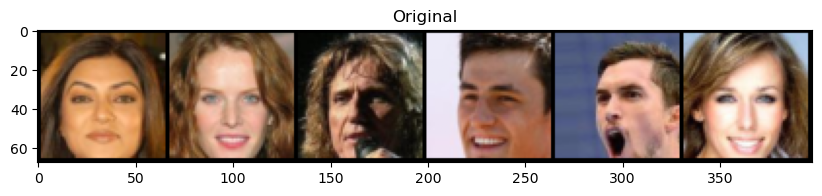

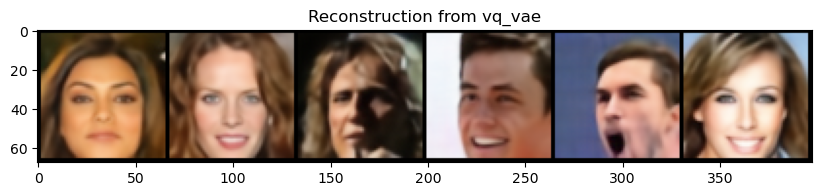

In [11]:
num_imgs = 6
figsize_reconstruction = (10, 30)
figsize_samples = (10, 10)
plot_reconstruction(vae, batch, num_of_samples=num_imgs, num_of_images_per_row=num_imgs)

100%|██████████| 10/10 [00:00<00:00, 29.23it/s]


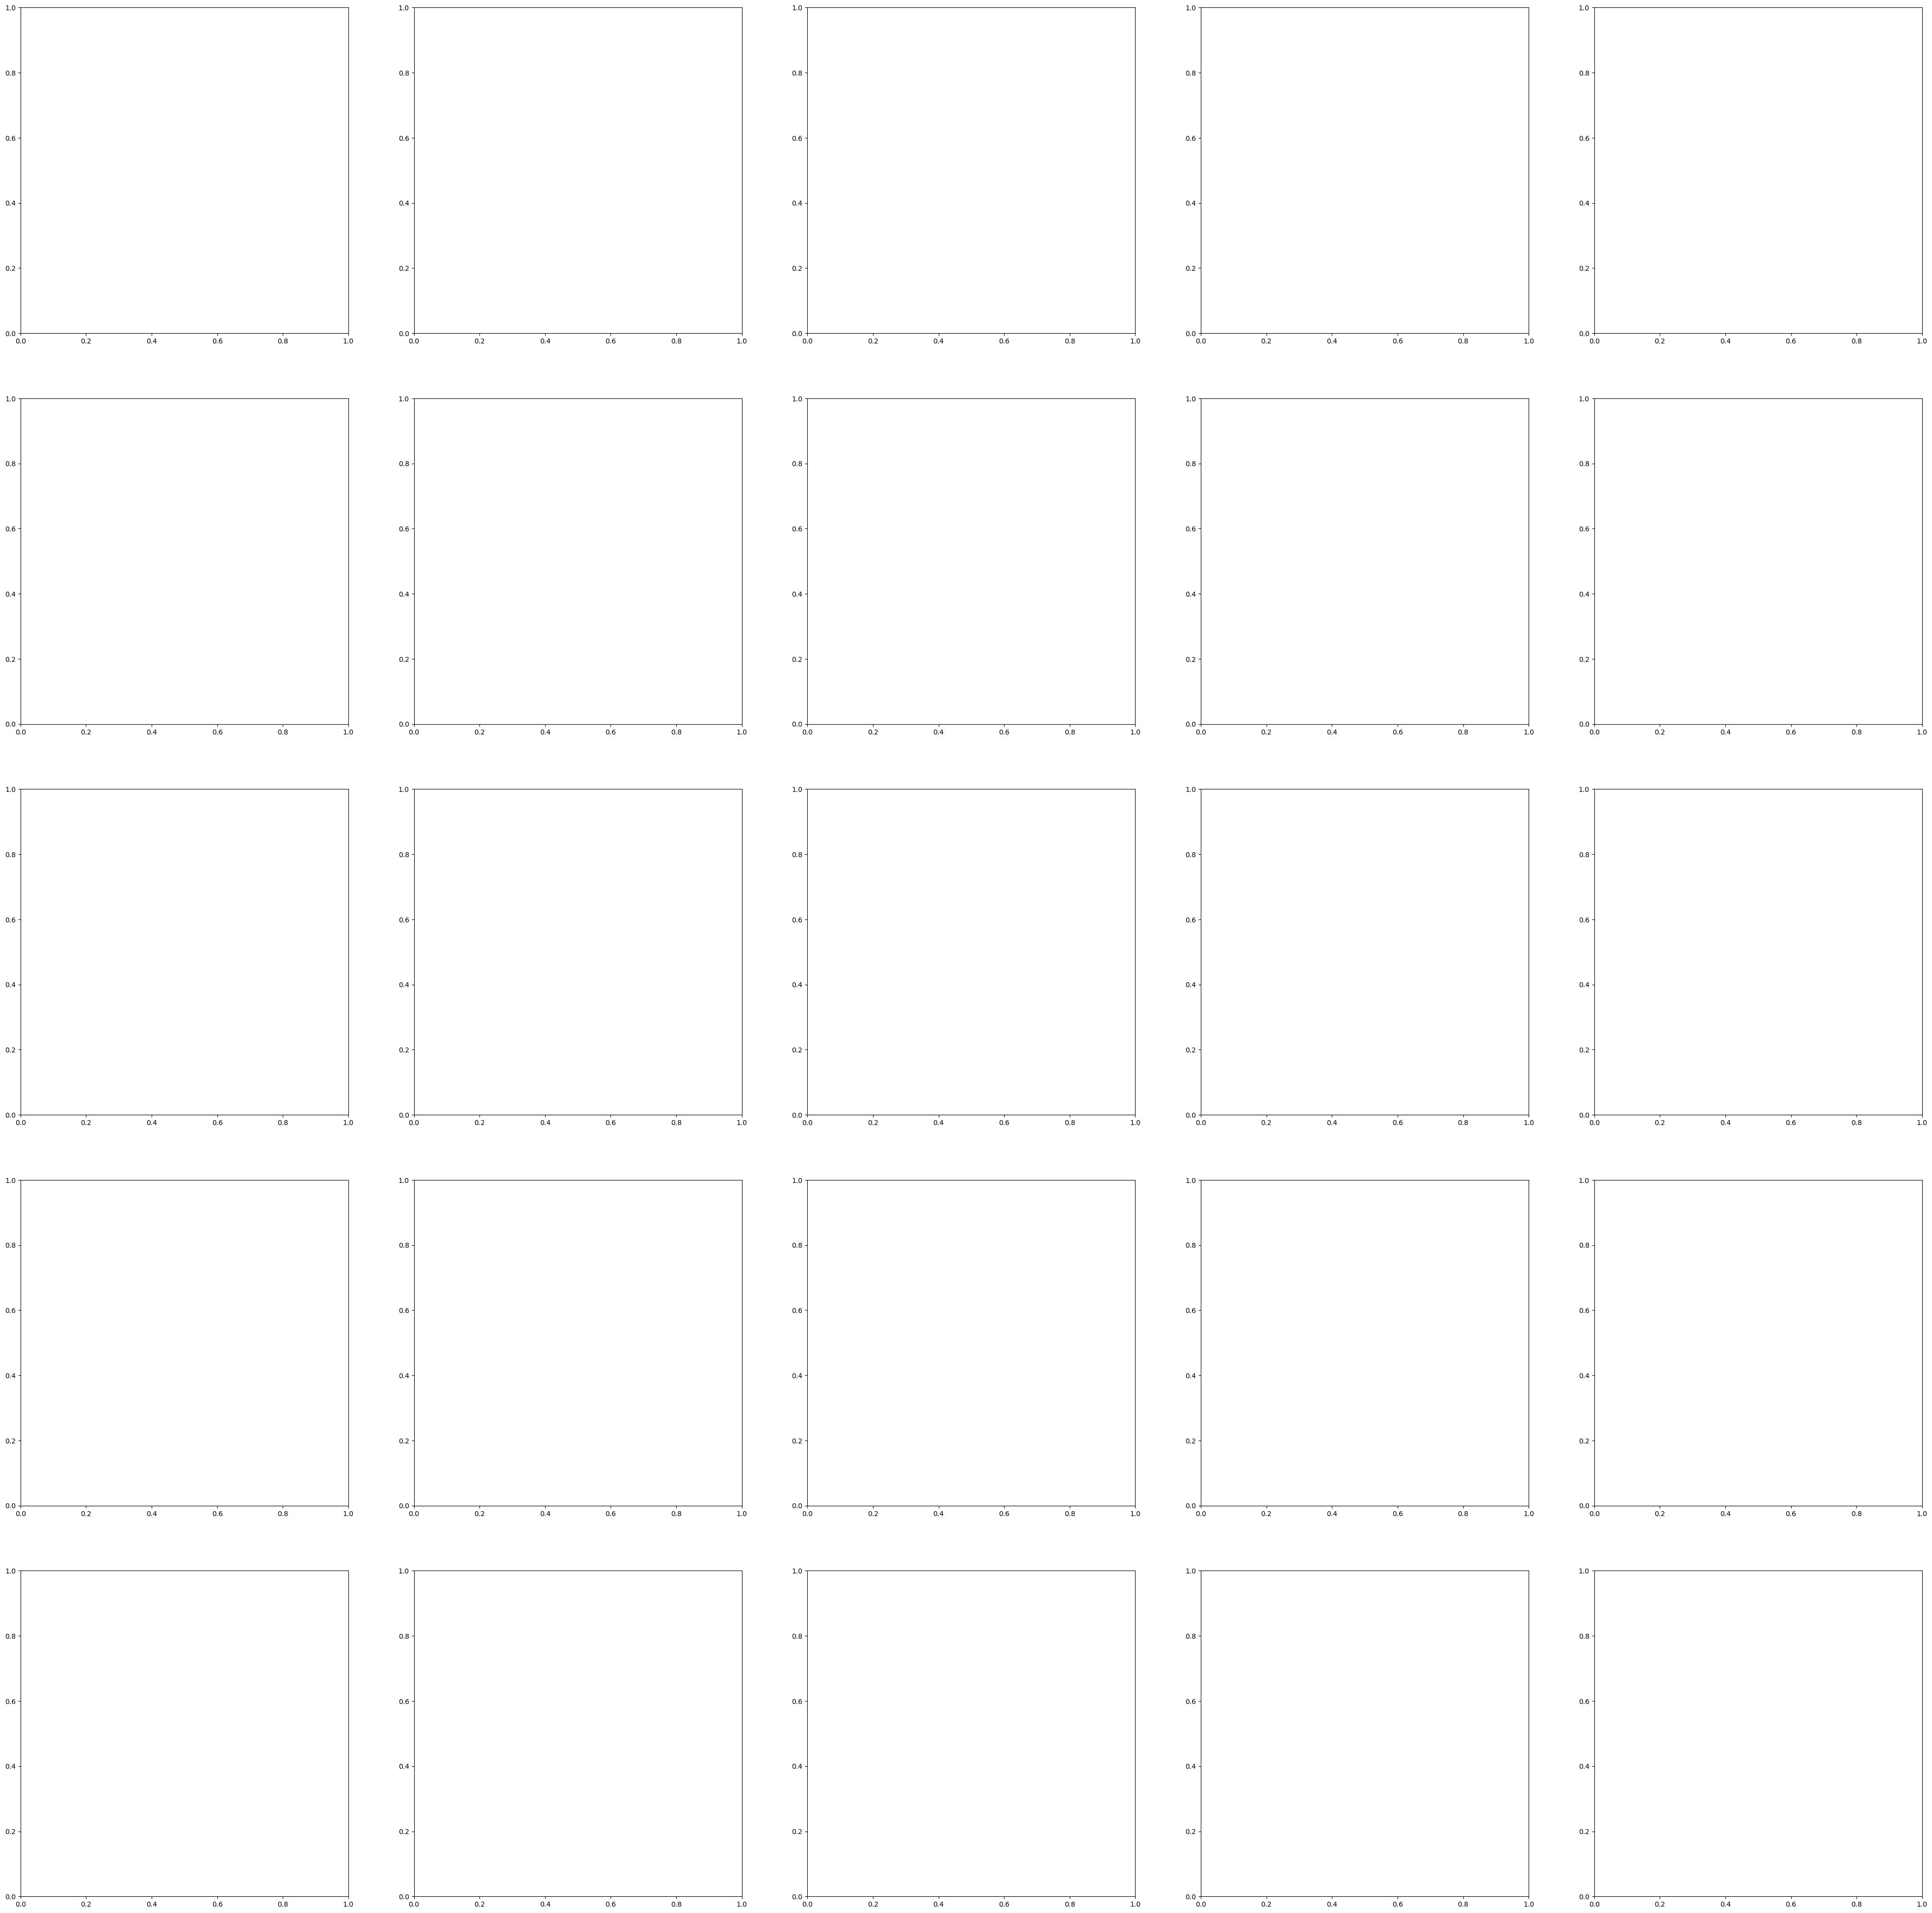

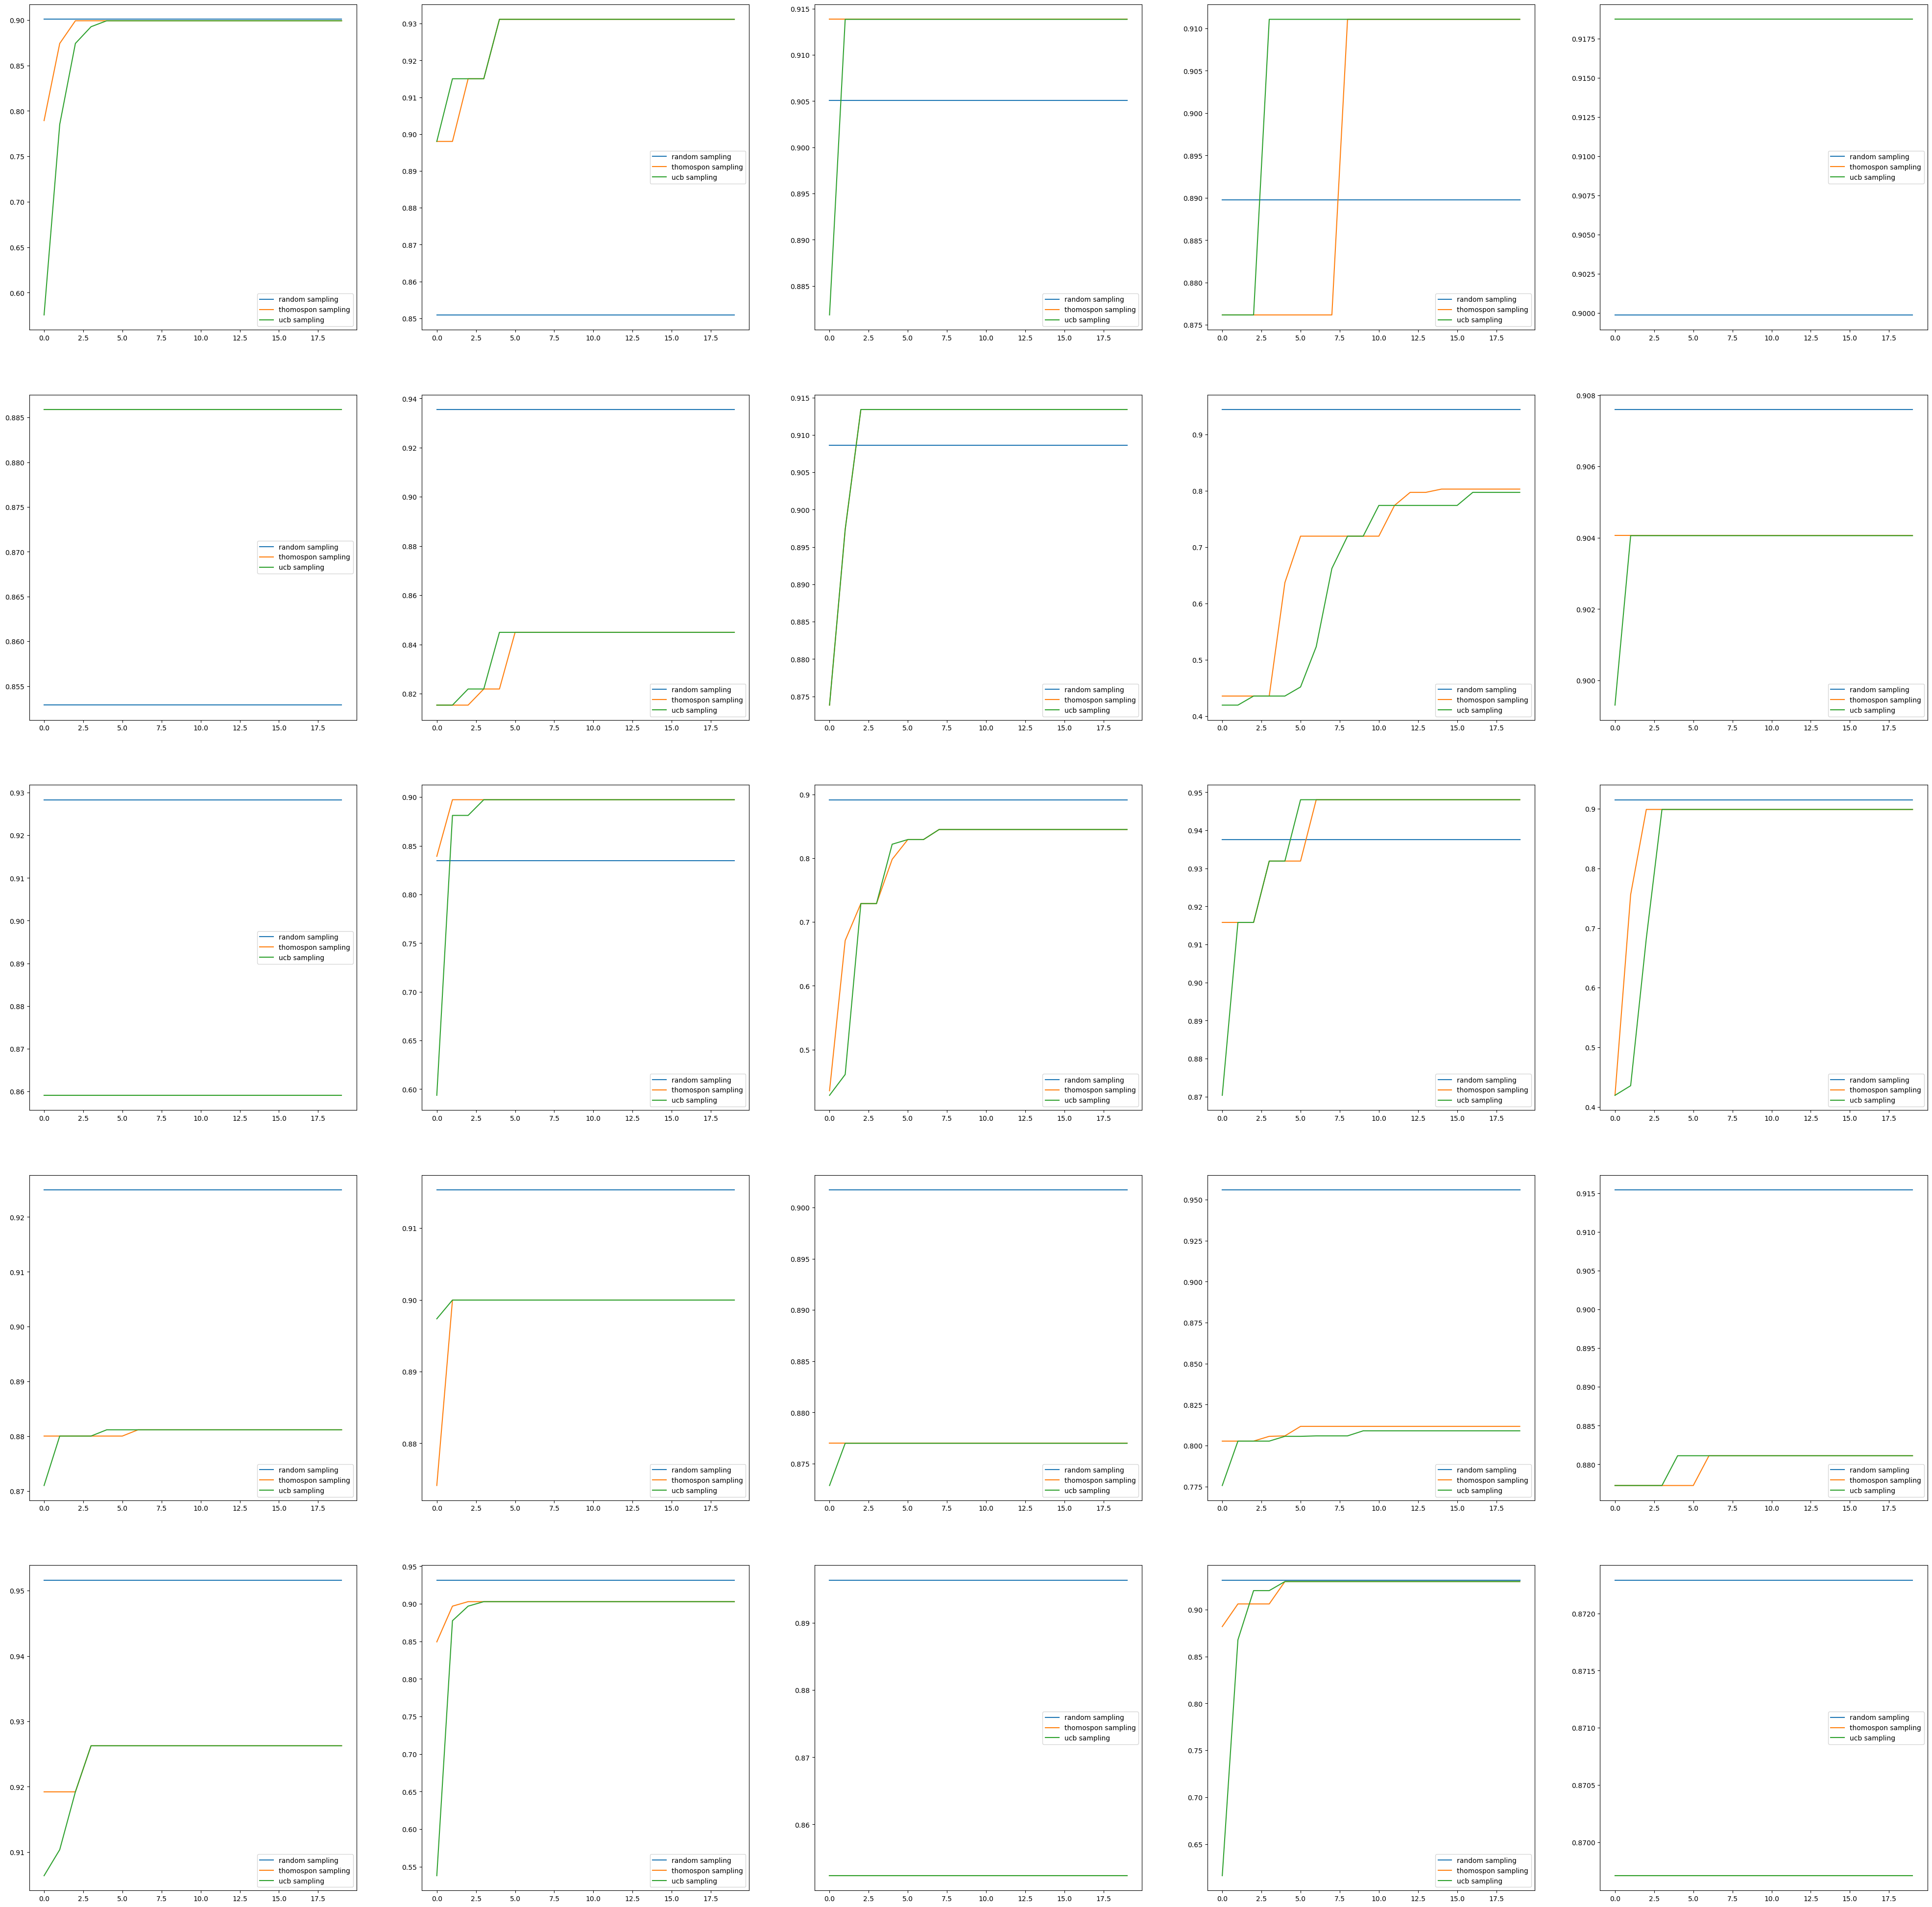

In [ ]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def experiment(config, x):
    ebm = make_energy_model(config, path=path)
    
    # The math
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    
    # The result
    fig, axs = plt.subplots(nrows = 1, ncols = 3)
    axs[0].set_title("original")
    axs[0].imshow(plotable(x))
    axs[1].set_title("denoising")
    axs[1].imshow(plotable(x_tilde))
    axs[2].set_title("estimation")
    axs[2].imshow(plotable(x_hat))
    plt.show()